In [33]:
%pip install qiskit qiskit-nature qiskit-algorithms pyscf 

Note: you may need to restart the kernel to use updated packages.


In [34]:
import numpy as np
from qiskit_nature.second_q.hamiltonians import ElectronicEnergy
from qiskit_nature.second_q.operators import ElectronicIntegrals
from qiskit_nature.second_q.problems import ElectronicStructureProblem
from qiskit_nature.second_q.mappers import JordanWignerMapper
from qiskit_nature.second_q.algorithms import GroundStateEigensolver
from qiskit_algorithms import NumPyMinimumEigensolver
from scipy.special import erf

def nuclear_electronic_potential(r_electron, nuclei):
    """
    Compute nuclear-electronic potential at a given electron position.
    """
    potential = 0.0
    for charge, r_nucleus in nuclei:
        r_nucleus = np.array(r_nucleus)
        distance = np.linalg.norm(r_electron - r_nucleus)
        if distance > 1e-10:
            potential += charge / distance
    return potential

def compute_one_electron_integrals(nuclei):
    """
    Compute the one-electron integrals (kinetic + nuclear attraction).
    """
    alpha = [3.42525091, 0.62391373, 0.16885540]
    S = np.zeros((2, 2))
    T = np.zeros((2, 2))
    V = np.zeros((2, 2))
    
    for i in range(2):
        for j in range(2):
            r_ij = np.linalg.norm(np.array(nuclei[i][1]) - np.array(nuclei[j][1]))
            S[i, j] = np.exp(-alpha[i] * alpha[j] * r_ij ** 2)
            T[i, j] = alpha[i] * alpha[j] * (3 - 2 * alpha[i] * alpha[j] * r_ij ** 2) * S[i, j]
            for charge, r_nucleus in nuclei:
                r_nucleus = np.array(r_nucleus)
                r_in = np.linalg.norm(r_nucleus - np.array(nuclei[i][1]))
                r_jn = np.linalg.norm(r_nucleus - np.array(nuclei[j][1]))
                V[i, j] += -charge * erf(r_in + r_jn) * S[i, j] / (r_in + r_jn + 1e-10)
    
    return T + V

def compute_two_electron_integrals(nuclei):
    """
    Compute the two-electron integrals (electron-electron repulsion).
    """
    two_electron_integrals = np.zeros((2, 2, 2, 2))
    
    for p in range(2):
        for q in range(2):
            for r in range(2):
                for s in range(2):
                    r_pq = np.linalg.norm(np.array(nuclei[p][1]) - np.array(nuclei[q][1]))
                    r_rs = np.linalg.norm(np.array(nuclei[r][1]) - np.array(nuclei[s][1]))
                    two_electron_integrals[p, q, r, s] = 1 / (r_pq + r_rs + 1e-10)
    
    return two_electron_integrals

# Define anti-HeH+ system
nuclei = [(-2, (0.0, 0.0, 0.0)), (-1, (0.0, 0.0, 1.0))]

# Compute integrals
one_electron_integrals = compute_one_electron_integrals(nuclei)
two_electron_integrals = compute_two_electron_integrals(nuclei)

# Validate integrals
assert np.allclose(one_electron_integrals, one_electron_integrals.T), "One-electron integral matrix is not symmetric!"
assert np.allclose(two_electron_integrals, two_electron_integrals.transpose(1, 0, 3, 2)), "Two-electron integral tensor is not symmetric!"

# Create the ElectronicEnergy Hamiltonian
electronic_energy = ElectronicEnergy.from_raw_integrals(one_electron_integrals, two_electron_integrals)

# Define the electronic structure problem
problem = ElectronicStructureProblem(electronic_energy)

# Map the problem to qubit operators
mapper = JordanWignerMapper()
qubit_hamiltonian = mapper.map(problem.second_q_ops()[0])

# Solve using a classical solver
solver = NumPyMinimumEigensolver()
ground_state_solver = GroundStateEigensolver(mapper, solver)
result = ground_state_solver.solve(problem)

print("Constructed Qubit Hamiltonian:", qubit_hamiltonian)
print("Computed Ground State Energy:", result.total_energies[0])


Constructed Qubit Hamiltonian: SparsePauliOp(['IIII', 'IIIZ', 'IIYY', 'IIXX', 'IIZI', 'IZII', 'YYII', 'XXII', 'ZIII', 'IIZZ', 'IZIZ', 'IZYY', 'IZXX', 'YYIZ', 'XXIZ', 'YYYY', 'XXYY', 'YYXX', 'XXXX', 'ZIIZ', 'ZIYY', 'ZIXX', 'IZZI', 'YYZI', 'XXZI', 'ZIZI', 'ZZII'],
              coeffs=[ 1.50000000e+10+0.j, -7.50000002e+09+0.j,  4.88508197e-01+0.j,
  4.88508197e-01+0.j, -7.50000000e+09+0.j, -7.50000002e+09+0.j,
  4.88508197e-01+0.j,  4.88508197e-01+0.j, -7.50000000e+09+0.j,
  2.50000000e+09+0.j,  2.50000000e+09+0.j, -2.50000000e-01+0.j,
 -2.50000000e-01+0.j, -2.50000000e-01+0.j, -2.50000000e-01+0.j,
  1.25000000e-01+0.j,  1.25000000e-01+0.j,  1.25000000e-01+0.j,
  1.25000000e-01+0.j,  2.50000000e+09+0.j, -2.50000000e-01+0.j,
 -2.50000000e-01+0.j,  2.50000000e+09+0.j, -2.50000000e-01+0.j,
 -2.50000000e-01+0.j,  2.50000000e+09+0.j,  2.50000000e+09+0.j])
Computed Ground State Energy: -3.7157050849236645e-06


In [35]:
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


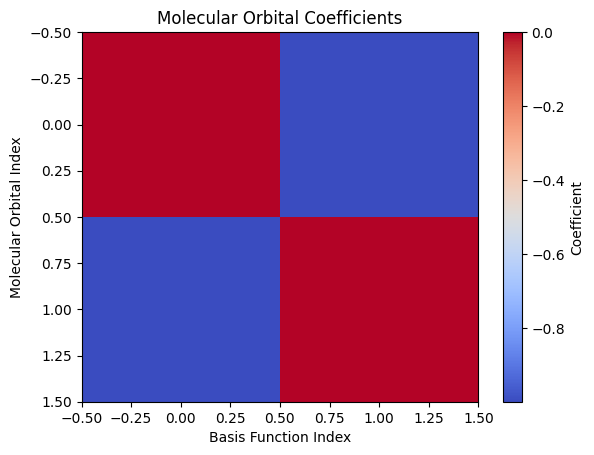

In [36]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
orbitals = np.linalg.eigh(one_electron_integrals)[1]
cax = ax.imshow(orbitals, cmap='coolwarm', aspect='auto')
fig.colorbar(cax, ax=ax, label='Coefficient')
ax.set_title('Molecular Orbital Coefficients')
ax.set_xlabel('Basis Function Index')
ax.set_ylabel('Molecular Orbital Index')
plt.show()
